# Applications: Econometrics

## Preliminaries: Drawing bivariate samples

In most of the exercises below, we'll need to draw a random sample that serves as an input. 
We therefore first define a routine which returns a sample drawn from a bivariate normal distribution.

In line with what we learned in unit 10, we check arguments and raise and exception if a an invalid value is encountered.

In [90]:
import numpy as np
from numpy.random import default_rng

def draw_bivariate_sample(mean, std, rho, n, seed=123):
    """
    Draw a bivariate normal random sample.

    Parameters
    ----------
    mean : array_like
        Length-2 array of means
    std : array_like
        Length-2 array of standard deviations
    rho : float
        Correlation parameter
    n : int
        Sample size
    """

    if not -1 <= rho <= 1:
        raise ValueError(f'Invalid correlation parameter: {rho}')

    if np.any(np.array(std) <= 0):
        raise ValueError(f'Invalid standard deviation: {std}')

    if n <= 0:
        raise ValueError(f'Invalid sample size: {n}')

    # initialize default RNG with given seed
    rng = default_rng(seed)

    # Unpack standard deviations for each dimension
    std1, std2 = std

    # Compute covariance
    cov = rho * std1 * std2

    # Create variance-covariance matrix
    vcv = np.array([[std1**2.0, cov],
                    [cov, std2**2.0]])

    # Draw MVN random numbers:
    # each row represents one sample draw.
    X = rng.multivariate_normal(mean=mean, cov=vcv, size=n)

    return X

## Singular value decomposition (SVD) and principal components

Singular value decomposition is a matrix factorisation that is commonly use in econometrics and statistics. 
For example, we can use it to implement principal component analysis (PCA),
principal component regression, OLS or Ridge regression.

Let $\mathbf{X} \in R^{m\times n}$ be a matrix. For our purposes, we will assume
that $m \geq n$ since $\mathbf{X}$ will be the matrix containing the data with
observations in rows and variables in column.
The (compact) SVD of $\mathbf{X}$ is given by
$$\mathbf{X} = \mathbf{U} \Sigma \mathbf{V}'$$
where $\mathbf{U} \in R^{m\times n}$ and 
$\mathbf{V} \in R^{n\times n}$ are orthogonal matrices,
and $\Sigma \in R^{n \times n}$ is a diagonal matrix
$$\Sigma =  \begin{bmatrix} 
    \sigma_1 & & & & \\
     & \sigma_2 & & & \\
     & & \ddots & & \\
     & & & \sigma_n & 
\end{bmatrix}$$
The elements $\sigma_i$ are called singular values of $\mathbf{X}$, and $\Sigma$
is arranged such that $\sigma_1 \geq \sigma_2 \geq \dots \geq \sigma_n$.
Since $\mathbf{U}$ is not necessarily square, it's not truly orthogonal, but its
columns are still orthogonal to each other.

These matrices satisfy the following useful properties:
$$
\def\bV{\mathbf{V}}
\def\bU{\mathbf{U}}
\def\bI{\mathbf{I}}
\begin{aligned}
    \bU' \bU &= \bI_n \\
    \bV' \bV &= \bV\bV' = \bI_n \\
    \bV' &= \bV^{-1}
\end{aligned}
$$

In Python, we compute the SVD using the 
[`svd()`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html) 
function from `numpy.linalg`.

### Example: Bivariate normal

Imagine we construct $X$ as 10 random draws from a bivariate normal:

Text(0.5, 1.0, 'Draws from bivariate normal distribution')

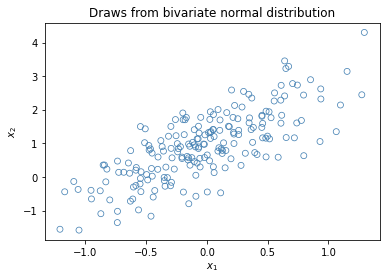

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng

# Draw a bivariate normal sample using the function we defined above
mu = [0.0, 1.0]         # Vector of means
sigma = [0.5, 1.0]      # Vector of standard deviations
rho = 0.75              # Correlation coefficient
Nobs = 200              # Sample size
X = draw_bivariate_sample(mu, sigma, rho, Nobs)
x1, x2 = X.T

# Scatter plot of sample
plt.scatter(x1, x2, linewidths=0.75, c='none', edgecolors='steelblue')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Draws from bivariate normal distribution')

We can now perform the SVD as follows:

In [92]:
from numpy.linalg import svd

# svd() returns transposed V!
# We use full_matrices=False to get the compact factorisation, otherwise
# U is 200 x 200.
U, S, Vt = svd(X, full_matrices=False)

In [93]:
# Check that U'U is a 2x2 identity matrix
U.T @ U         # or np.dot(U.T, U)

array([[ 1.00000000e+00, -6.12878704e-17],
       [-6.12878704e-17,  1.00000000e+00]])

In [94]:
# Check that V'V = VV' is a 2x2 identity matrix
Vt.T @ Vt       # or np.dot(Vt.T, Vt)

array([[ 1.00000000e+00, -2.26167254e-18],
       [-2.26167254e-18,  1.00000000e+00]])

In [95]:
# svd() does not return S as a matrix but only its diagonal!
S

array([19.73152572,  5.99498933])

In [96]:
# We can convert it to a diagonal matrix using np.diag()
np.diag(S)

array([[19.73152572,  0.        ],
       [ 0.        ,  5.99498933]])

### Example: Principal components

We use principal component analysis (PCA) as a dimension reduction technique,
which allows us to identify an alternate set of axes along which the data
in $\mathbf{X}$ varies the most. In machine learning, PCA is one of the
most basic unsupervised learning techniques.

To perform the PCA, it is recommended to first demean the data:

In [97]:
X = draw_bivariate_sample(mu, sigma, rho, Nobs)

# Demean variables in X
Xmean = np.mean(X, axis=0)

# Matrix Z stores the demeaned variables
Z = X - Xmean[None]

We can now use the SVD factorisation to compute the principal components. 
Once we have computed the matrices $\mathbf{U}$, $\Sigma$ and $\mathbf{V}$,
the matrix of principal components (one in each column) is given by
$$
PC = \mathbf{U} \Sigma
$$

In [98]:
# Apply SVD to standardised values
U, S, Vt = svd(Z, full_matrices=False)

# Compute principal components
PC = U * S          # same as U @ np.diag(S)

# Variance of each PC is highest for first component
var_PC = np.var(PC, axis=0, ddof=1)
print(f'Principal component variances: {var_PC}')

Principal component variances: [1.17607859 0.09444617]


We can now  plot the principal component axes in the original data space.
The right column shows the data rotated and rescaled so that each
axes now corresponds to a principal component. Most of the variation
clearly occurs along the first axis!

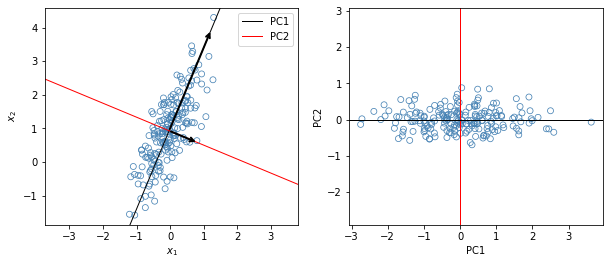

In [99]:
# Plot principal components

# Scatter plot of sample
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].scatter(X[:, 0], X[:, 1], linewidths=0.75, c='none', edgecolors='steelblue')
axes[0].axis('equal')
axes[0].set_xlabel(r'$x_1$')
axes[0].set_ylabel(r'$x_2$')
axes[0].axline(Xmean, Xmean + Vt[0], label='PC1', lw=1.0, c='black', zorder=1)
axes[0].axline(Xmean, Xmean + Vt[1], label='PC2', lw=1.0, c='red', zorder=1)

PC_arrows = Vt * np.sqrt(var_PC[:, None])
for v in PC_arrows:
    # Scale up arrows by 3 aAso that they are visible!
    axes[0].annotate('', Xmean + v*3, Xmean, arrowprops=dict(arrowstyle='->', linewidth=2))

axes[0].legend()

# Plot in principal component coordinate system
axes[1].scatter(PC[:, 0], PC[:, 1], linewidths=0.75, c='none', edgecolors='steelblue')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].axis('equal')
axes[1].axvline(0.0, lw=1.0, c='red')
axes[1].axhline(0.0, lw=1.0, c='black')

Of course, in real applications we don't need to manually compute the
principal components, but can use a library such as 
[scikit-learn](https://scikit-learn.org/stable/) to do it for us:

In [100]:
from sklearn.decomposition import PCA

X = draw_bivariate_sample(mu, sigma, rho, Nobs)

# Create PCA with 2 components (which is the max, since we have only two 
# variables)
pca = PCA(n_components=2)

# Perform PCA on input data
pca.fit(X)

# The attribute components_ can be used to retrieve the V' matrix
print("Principal components (matrix V'):")
print(pca.components_)

# The attribute explained_variance_ stores the variances of all PCs
print(f'Variance of each PC: {pca.explained_variance_}')

# Fraction of variance explained by each component:
print(f'Fraction of variance of each PC: {pca.explained_variance_ratio_}')

Principal components (matrix V'):
[[ 0.38420018  0.92324981]
 [ 0.92324981 -0.38420018]]
Variance of each PC: [1.17607859 0.09444617]
Fraction of variance of each PC: [0.92566365 0.07433635]


## Ordinary least squares (OLS)

Consider the regression 
$$
y_i = x_i' \beta + u_i
$$
where $x_i$ is a vector of regressors (explanatory variables) 
that is assumed to include a constant.
Recall that the OLS estimator $\widehat{\beta}$ is given by 
$$
\widehat{\beta} = \left(X'X\right)^{-1}X'y
$$
where $X$ is the regressor matrix that contains all stacked $x_i'$,
and $y$ contains all observations of the dependent variable.

### Example 1: Bivariate data

We first demonstrate how to compute $\beta$ using bivariate normal data,
to the regression simplifies to
$$
y_i = \alpha + \beta x_i + u_i
$$
where $\alpha$ is the intercept and $\beta$ is the slope coefficient.
In this special case, the population coefficient $\beta$ can be computed 
using the formula
$$
\beta = \frac{E[(Y-\overline{Y})(X-\overline{X})]}{E[(X-\overline{X})]}
 = \frac{Cov(Y,X)}{Var(X)}
$$
there the numerator contains the covariance of the random variables $Y$ and $X$, 
and the denominator contains the variance of $X$.
Given a sample of values, the estimator $\widehat{\beta}$
is computed using the corresponding sample moments:
$$
\widehat{\beta} = \frac{\widehat{Cov}(y,x)}{\widehat{Var}(x)}
$$

Slope of population regression line: -1.5
Slope of sample regression line: -1.3889613032802288


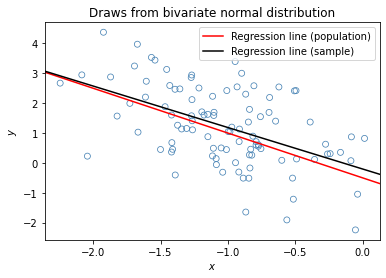

In [101]:
import numpy as np
import matplotlib.pyplot as plt

mu = [-1.0, 1.0]                # Mean of X and Y
std = [0.5, 1.5]                # Std. dev. of X and Y
rho = -0.5                      # Correlation coefficient
Nobs = 100                      # Sample size

# We transpose the return value and unpack individual rows into X and Y
x, y = draw_bivariate_sample(mu, std, rho, Nobs).T

# Compute beta (slope coefficient) from distribution moments.
# This is the true underlying relationship given our data generating process.
cov = rho * np.prod(std)
beta = cov / std[0]**2.0
print(f'Slope of population regression line: {beta}')

# Compute beta from sample moments
# Sample variance-covariance matrix (ddof=1 returns the unbiased estimate)
cov_hat = np.cov(x, y, ddof=1)[0, -1]
var_x_hat = np.var(x, ddof=1)
beta_hat = cov_hat / var_x_hat
# Sample intercept
alpha_hat = np.mean(y) - beta_hat * np.mean(x)

print(f'Slope of sample regression line: {beta_hat}')

# Scatter plot of sample
plt.scatter(x, y, linewidths=0.75, c='none', edgecolors='steelblue')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title('Draws from bivariate normal distribution')
plt.axline(mu, slope=beta, color='red', label='Regression line (population)')
plt.axline((0, alpha_hat), slope=beta_hat, color='black', label='Regression line (sample)')
plt.legend()

### Example 2: OLS using matrix algebra

With more than one regressor, we need to use matrix algebra to perform
the OLS estimation. For demonstration purposes, we continue
using the bivariate data generated above, but now we write the OLS regression
as
$$
y_i = \mathbf{x}_i' \gamma + u_i
$$
where $\gamma = (\alpha, \beta)$, and the regressors now contain a constant,
$\mathbf{x_i} = (1, x_i)'$. As stated above, the OLS estimator
is given by
$$
\widehat{\gamma} = \left(X'X\right)^{-1}X'y
$$

#### Naive solution

You might be tempted to solve the above equation system by explicitly 
computing the inverse of $X'X$ using NumPy's 
[`inv()`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.inv.html)
like this:

In [102]:
from numpy.linalg import inv

# We transpose the return value and unpack individual rows into X and Y
x, y = draw_bivariate_sample(mu, std, rho, Nobs).T

# Create vector of ones (required to estimate the intercept)
ones = np.ones((len(x), 1))
# Prepend constant to vector of regressors to create regressor matrix X
X = np.hstack((ones, x[:, None]))
XXinv = inv(X.T @ X)

# Print naive (X'X)^-1
print("Naive (X'X)^(-1):")
print(XXinv)

# Compute naive estimate of gamma
gamma_naive = XXinv @ X.T @ y
print(f'Naive estimate of gamma: {gamma_naive}')

Naive (X'X)^(-1):
[[0.05633363 0.04521468]
 [0.04521468 0.04412275]]
Naive estimate of gamma: [-0.20352351 -1.3889613 ]


This might seems like a straightforward way to implement OLS, but in
practice you should *never* do this. Explicitly taking the inverse of a matrix to solve an equation system is rarely a good idea and numerically unstable, even though in this particular
case it yields the same result!

#### Solving as a linear equation system

One numerically acceptable way to run OLS is to view it as a linear equation system.
Recall that a linear equation system can be written in matrix notation as
$$
\mathbf{A} \mathbf{x} = \mathbf{b}
$$
where $\mathbf{A} \in R^{k \times k}$ is a coefficient matrix of full rank, 
$\mathbf{b} \in R^k$ is a vector, and 
$\mathbf{x} \in R^k$ is a vector of $k$ unknows we want to solve for. The OLS
estimator can be written in this form if we set
$$
\begin{aligned}
    \mathbf{A} &= \mathbf{X}'\mathbf{X} \\
    \mathbf{b} &= \mathbf{X}'\mathbf{y} \\
    \mathbf{z} &= \widehat{\gamma}
\end{aligned}
$$
so that we have
$$
    (\mathbf{X}'\mathbf{X})\widehat{\gamma} = \mathbf{X}'\mathbf{y}
$$
We can use NumPy's [`solve()`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html)
to find $\widehat{\gamma}$:

Of course, running OLS (or equivalently: solving an overdetermined
linear equation system) is a common task, so NumPy has the 
function 
[`solve()`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html)
which allows you do to it without explicitly computing
$\mathbf{X}'\mathbf{X}$ or $\mathbf{X}'\mathbf{y}$:

In [103]:
from numpy.linalg import solve

# Compute X'X
A = X.T @ X
# Compute X'y
b = X.T @ y

# Solve for coefficient vector
gamma_solve = solve(A, b)
print(f'Estimate of gamma using solve(): {gamma_solve}')

Estimate of gamma using solve(): [-0.20352351 -1.3889613 ]


In [104]:
from numpy.linalg import lstsq

# Estimate using lstsq(). Pass rcond=None to suppress a warning.
gamma_lstsq, *rest = lstsq(X, y, rcond=None)

print(f'Estimate of gamma using lstsq(): {gamma_lstsq}')

Estimate of gamma using lstsq(): [-0.20352351 -1.3889613 ]


### Example 3: Implementing OLS yourself

NumPy's `lstsq()` uses SVD to compute the solution. Since we covered
SVD in a previous exercise, we already have the tools to build our own implementation.

Recall that SVD factorises a regressor matrix $\mathbf{X}$ into three 
matrices,
$$
\mathbf{X} = \mathbf{U} \Sigma \mathbf{V}'
$$
We can use the orthogonality properties of $\mathbf{U}$ and $\mathbf{V}$
from the previous exercise to transform the OLS estimator. Note that
we are using the fact that the transpose of $\mathbf{X}$ is 
$$
\mathbf{X}' = \mathbf{V} \Sigma' \mathbf{U}' = 
    \mathbf{V} \Sigma \mathbf{U}'
$$
which follows since $\Sigma$ is a diagonal (and thus symmetric) matrix.
The OLS estimator can then be expressed as follows:
$$
\def\bV{\mathbf{V}}
\def\bX{\mathbf{X}}
\def\bU{\mathbf{U}}
\def\bY{\mathbf{y}}
\def\ident{\mathbf{I}}
\begin{aligned}
\widehat{\gamma} &= (\mathbf{X}'\mathbf{X})^{-1}\mathbf{X}'\mathbf{y} \\
    &= \left(\bV \Sigma \bU' \bU \Sigma \bV' \right)^{-1}
        \bV \Sigma \bU' \bY \\
    &= \left(\bV \Sigma \ident_k \Sigma \bV' \right)^{-1}
        \bV \Sigma \bU' \bY \\
    &= \left(\bV \Sigma^2 \bV' \right)^{-1}
        \bV \Sigma \bU' \bY \\
\end{aligned}
$$
This follows since $\mathbf{U}'\mathbf{U} = \mathbf{I}_k$ is an identity matrix where $k=2$
is the number of coefficients we are estimating.
Next, we can compute the inverse using the orthogonality properties of 
$\mathbf{V}$ which imply that
$$
\def\bV{\mathbf{V}}
\begin{aligned}
    \bV\bV' &= \bV'\bV = \mathbf{I} \\
    \bV' &= \bV^{-1}
\end{aligned}
$$
Therefore, 
$$
\def\bV{\mathbf{V}}
\begin{aligned}
    \left(\bV \Sigma^2 \bV' \right)^{-1} =
    (\bV')^{-1} \Sigma^{-2} \bV^{-1} = \bV \Sigma^{-2} \bV'
\end{aligned}
$$
Plugging this into the expression for the OLS estimator, we see that
$$
\def\bV{\mathbf{V}}
\def\bU{\mathbf{U}}
\def\bY{\mathbf{y}}
\def\ident{\mathbf{I}}
\begin{aligned}
\widehat{\gamma} 
    &= \left(\bV \Sigma^2 \bV' \right)^{-1} \bV \Sigma \bU' \bY \\
    &= \bV \Sigma^{-2} \bV' \bV \Sigma \bU' \bY \\
    &= \bV \Sigma^{-2} \ident_k \Sigma \bU' \bY \\
    &= \bV \Sigma^{-1} \bU' \bY
\end{aligned}
$$
Why is this preferable to the original expression? Since $\Sigma$ is 
a diagonal matrix, its inverse is trivially computed as the element-wise
inverse of its diagonal elements!

In [105]:
from numpy.linalg import svd

# Request "compact" SVD, we don't need the full matrix U.
U, S, Vt = svd(X, full_matrices=False)

# Note that S returned by svd() is a vector that contains the diagonal
# of the matrix Sigma.
gamma_svd = Vt.T * S**(-1) @ U.T @ y
print(f'Estimate of gamma using SVD: {gamma_svd}')

Estimate of gamma using SVD: [-0.20352351 -1.3889613 ]


### Example 4: OLS standard errors

All of the above methods only computed the *point estimates* of the coefficient vector. Usually, we are interested in performing inference, i.e., testing some hypothesis, for example whether our estimate
is significantly difference from zero. To this end, we need to compute standard errors
which reflect the sampling uncertainty of our estimates.

Under the assumption of 
[homoskedastic](https://en.wikipedia.org/wiki/Homoscedasticity) errors,
the variance-covariance matrix of the OLS estimator $\widehat{\gamma}$ is given by
the expression
$$
\begin{aligned}
Var(\widehat{\gamma}) &= \widehat{\sigma}^2 \left(\mathbf{X}'\mathbf{X}\right)^{-1} \\
\widehat{\sigma}^2 &= \frac{1}{1-n} \sum_{i=1}^n \widehat{u}_i^2
\end{aligned}
$$
where $\widehat{\sigma}^2$ is the sample variance of the residuals
(recall that we have included an intercept in the model, so the mean
of $\widehat{u}_i$ is zero!).

Luckily, we can directly use our insights from the previous section and
instead of computing $\left(\mathbf{X}'\mathbf{X}\right)^{-1}$ directly
(which is numerically undesirable), we can rewrite it using the SVD
factorisation as follows:
$$
\def\bV{\mathbf{V}}
\def\bX{\mathbf{X}}
\def\bU{\mathbf{U}}
\def\bY{\mathbf{y}}
\def\ident{\mathbf{I}}
\begin{aligned}
(\bX'\bX)^{-1}
    &= \left(\bV \Sigma \bU' \bU \Sigma \bV' \right)^{-1} \\
    &= \left(\bV \Sigma \ident_k \Sigma \bV' \right)^{-1} \\
    &= \left(\bV \Sigma^2 \bV' \right)^{-1} \\
    &= \bV \Sigma^{-2} \bV'
\end{aligned}
$$

Extending the code from above, we can now compute the point estimate and
the standard errors:

In [106]:
from numpy.linalg import svd

# Request "compact" SVD, we don't need the full matrix U.
U, S, Vt = svd(X, full_matrices=False)

# Compute point estimate as before
gamma = Vt.T * S**(-1) @ U.T @ y

# Compute (X'X)^-1 
XXinv = Vt.T * S**(-2) @ Vt

# Residuals are given as u = y - X*gamma
residuals = y - X @ gamma

# Variance of residuals
var_u = np.var(residuals, ddof=1)

# Variance-covariance matrix of estimates
var_gamma = var_u * XXinv

# Standard errors are square roots of diagonal elements of Var(gamma)
gamma_se = np.sqrt(np.diag(var_gamma))

print(f'Point estimate of gamma: {gamma}')
print(f'Standard errors of gamma: {gamma_se}')

Point estimate of gamma: [-0.20352351 -1.3889613 ]
Standard errors of gamma: [0.26393279 0.23358274]


### Example 5: Complete OLS estimation routine

We can combine all our previous code and encapsulate it in a function called `ols`,
which makes sure the input data are NumPy arrays and have the same number
of observations. We also add the optional parameter `add_const` which
allows callers to automatically include a constant in the model.

In [107]:
def ols(X, y, add_const=False):
    """
    Run the OLS regression y = X * beta + u
    and return the estimated coefficients beta and their variance-covariance
    matrix.

    Parameters
    ----------
    X : array_like
        Matrix (or vector) of regressors
    y : array_like
        Vector of observations of dependent variable
    add_const : bool, optional
        If True, prepend a constant to regressor matrix X.
    """

    # Make sure we have a regressor matrix even if there is only a single
    # regressor
    X = np.atleast_2d(X)
    y = np.atleast_1d(y)

    # Check that arrays are of conformable dimensions, and raise an exception
    # if that is not the case
    Nobs = y.size
    if X.shape[0] != Nobs:
        raise ValueError('Non-conformable arrays X and y')

    # Check whether we need to prepend a constant
    if add_const:
        ones = np.ones((Nobs, 1))
        X = np.hstack((ones, X))

    # Request "compact" SVD, we don't need the full matrix U.
    U, S, Vt = svd(X, full_matrices=False)

    # Compute point estimate using SVD factorisation
    beta = Vt.T * S**(-1) @ U.T @ y

    # Compute (X'X)^-1 using SVD factorisation
    XXinv = Vt.T * S**(-2) @ Vt

    # Residuals are given as u = y - X*beta
    residuals = y - X @ beta

    # Variance of residuals
    var_u = np.var(residuals, ddof=1)

    # Variance-covariance matrix of estimates
    var_beta = var_u * XXinv

    return beta, var_beta
